In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [3]:
!ls

datasetCSV.zip		 DetectedAuthorTwitter.ipynb  LICENSE
datasetHabrahabr.csv	 DetectedAuthorVK.ipynb       model
dataset.zip		 echo_posts_100_and_more.csv  posts.csv
DetectedAuthorRNN.ipynb  Habrahabr		      README.md


In [3]:
# Устанавливаем seed для повторяемости результатов
np.random.seed(42)

In [5]:
N = 10
with open("echo_posts_100_and_more.csv") as myfile:
    head = [next(myfile) for x in range(N)]
print(head)

['|Author|Text\n', '0|ААВ-старший|"\n', '\n', 'Я\xa0сожалею, что начало передачи с\xa0Леонидом Волковым было скомкано. \n', '\n', 'Приношу извинения тем слушателям Эха, которые сочли этот инцидент неуместным  \n', '\n', '«Эхо Москвы» готово предложить дебаты между Ксенией Собчак и\xa0Алексеем Навальным.  \n', 'Оригинал "\n', '1|ААВ-старший|"\n']


In [5]:
data = pd.read_csv('echo_posts_100_and_more.csv', sep='|', engine='python', index_col=0)
data.head()

,Author,Text
0,ААВ-старший,"\n\nЯ сожалею, что начало передачи с Леонидом ..."
1,ААВ-старший,"\n\nПонятно, почему Путин рассказывал о высоко..."
2,ААВ-старший,"\n\nСчитал и считаю, что отказ в регистрации А..."
3,ААВ-старший,\nО странностях жизни. \nПутин благодарит Тра...
4,ААВ-старший,\n\nВот интересно – начальник Службы безопасно...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87640 entries, 0 to 87436
Data columns (total 2 columns):
Author    87437 non-null object
Text      80168 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


In [4]:
data = pd.read_csv('posts.csv', names=['Author', 'Text'], sep=',', header=None)
data.head()

,Author,Text
0,22211,"Надо жить у моря, Мама.\n\nAdMe.ru публикует р..."
1,22211,Памятка трейдера.\n\nВыражения и термины приме...
2,22211,"Руслан Проводников или ""Сибирский Рокки"", как ..."
3,61454,"""Выбирай платья на лето"", ""готовься к лету вме..."
4,61454,"""Спят ли мамы?""- я не знала. На такой вопрос о..."


In [9]:
#from nltk.corpus import stopwords
#stop = stopwords.words('russian')
#data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#print('Stop words have been deleted')
#data['Text'].apply(lambda x: x.replace('\n', ' '));

### Подсчет количества слов в корпусе

In [7]:
data.Text = data.Text.apply(str);

In [5]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))

Количество статей в корпусе: 98442


### Удаление спам пользователей

In [6]:
spam_list = [301557842, 184330667, 191315693, 111604181, 212846761, 278053852, 281162155, 206300456, 306859957, 19006413, 275267400, 131629784, 276695686, 227968805, 65265920, 215657793, 212066696, 281866527, 172515637, 420657548, 259904924, 103086082, 36309849, 151622711, 304407589, 304407589, 234135027, 330779808, 135431520, 326927985, 22070189, 16497456, 22070189, 16497456, 120772826, 181255568, 24655736, 90966607, 102977537, 317336618, 189704404, 11663845, 57439210, 163452787, 38680483, 121144040, 211289578, 280155968, 198528079, 277512341, 33152119, 314327791, 229101154, 271546215, 4121239, 59729051, 288393060, 17620663, 296431137, 320666372, 153340241, 13309210, 333014765, 24595847, 152263680, 135815313, 27763994, 34902711, 200488318, 393710429, 400853612, 18091069, 232368999, 243123251, 159034443, 101820061, 334397479, 36372315, 18412482, 362494239, 98538332, 94983825, 171941220, 35386477, 179364423, 136668179, 57446172, 288223392, 321431512, 277994902, 190694040, 325021098, 129392296, 289027630, 216216545, 75884932, 208023062, 185965346, 2857932, 2574325, 154034429, 312715518, 286913827, 336049060, 163410643, 309938895, 372204020, 400615680, 235441786, 8391421, 136997064, 174934251, 173179778, 134275738, 93070783, 403039516, 326194938, 26960550, 18090797, 15931375, 64401851, 14665799, 223678239, 1963998, 252135842, 16352364, 386230491, 135103805, 335233013, 226605259, 94018354, 363143703, 278775919, 134780377,498638, 498638, 20403116, 824871, 22259914, 203601767, 386435681, 280519165, 225577927, 336493264, 203836012, 250362235, 135154139, 332671406, 296879545, 191398452, 48411613, 276175277, 77459397, 15155303, 6646818, 174692652, 25755928, 145799445, 210213078, 225680585, 167783297, 159347782, 154637631, 343704548, 276329737, 158954181, 7736592, 52430830, 54738353, 181641220, 249065698, 356566757, 12276180, 146475131, 38034256, 301152537, 181250759, 65169740, 229445819, 360098848, 204181735, 311981137, 9365217, 323032519, 144081373, 166471693, 219977388, 3252582, 92645976, 341675206, 394122042, 8469671, 293599275, 150564713, 315874927, 75299334, 395839270, 256327432, 8758868, 234523373, 234523373] 
print('Count of spam users:', len(spam_list))
lam = lambda row: row['Author'] not in spam_list
data = data[data.apply(lam, axis=1)]

Count of spam users: 201


In [7]:
author_count_news = data.Author.value_counts()
print('Количество авторов в корпусе:', len(author_count_news))
#print(author_count_news[:-8300: -1])
#author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

Количество авторов в корпусе: 8410


### Количество статей у каждого пользователя

In [10]:
# Попробовать изменить количество статей у автора, у каждого 10 постов, 50, 100

num_classes = 100
skip_person = 9
author_count_news_dubset = author_count_news[skip_person:skip_person+num_classes]

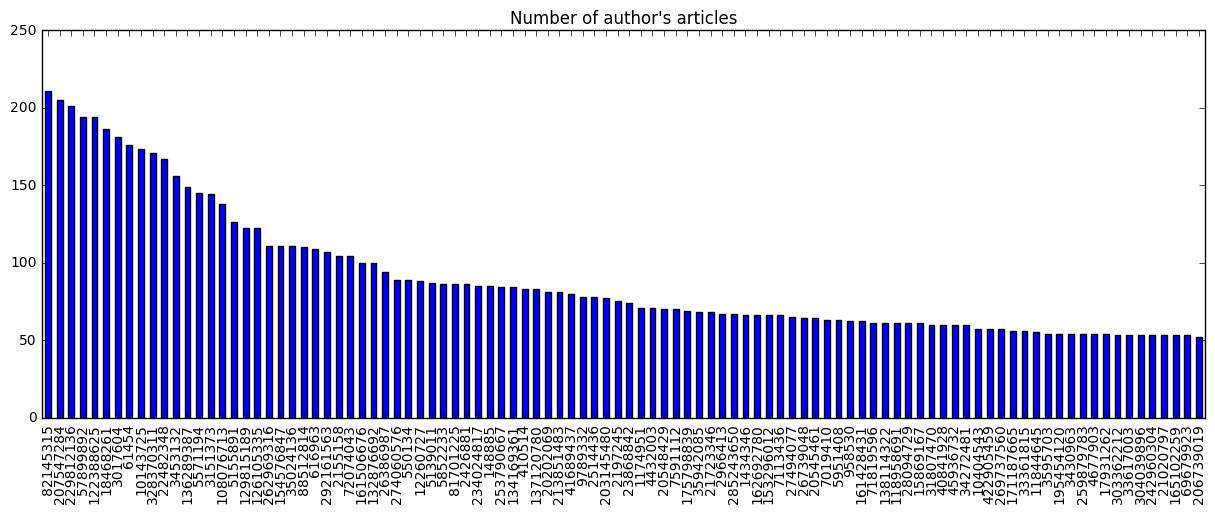

In [11]:
author_count_news_dubset.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

In [100]:
for i, (user_id, number) in enumerate(author_count_news.items()):
    print('User id', user_id)
    print(data[data.Author == user_id]['Text'][:2])
    print('===========')
    if i == 2:
        break

User id 2023105
2024    – Разве хегзы, это не те, кто взывает к легенд...
2025    — «Shoryuken» means «rising dragon fist», appa...
Name: Text, dtype: object
User id 225897827
70147    ✨✨ МОЙ МИР РАДУЕТ МЕНЯ СВОИМ ИЗОБИЛИЕМ И РАЗНО...
70148    "Мой новый взгляд на прощение или как я учусь ...
Name: Text, dtype: object
User id 82145315
32365    "... Полностью войдите в роль любителя, которы...
32366    "... Что бы мы ни говорили, что бы ни делали, ...
Name: Text, dtype: object


### Подготовка данных

In [12]:
temp_data = pd.DataFrame()
names_author = author_count_news_dubset.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 9019


In [16]:
# def remove_stopwords(data):
#     from nltk.corpus import stopwords
#     stop = stopwords.words('russian')
#     data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#     print('Stop words have been deleted')

In [17]:
# def get_lemmatization_corpus(data):
#     import pymorphy2
#     morph = pymorphy2.MorphAnalyzer()
#     data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
#     print('The lemmatization completed')

In [13]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data.head()

,Author,Text,CountWords
32365,61,"""... Полностью войдите в роль любителя, которы...",53
32366,61,"""... Что бы мы ни говорили, что бы ни делали, ...",35
32367,61,"""...в кафе они заказывают чужие воспоминания. ...",27
32368,61,"""...Нужно научиться дышать воздухом, иметь ден...",56
32369,61,"""...Там так далеко, там так далеко... Там нет ...",46


In [14]:
df = data
samplesize = 10  #number of samples that you want
sample_10 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

samplesize = 20  #number of samples that you want
sample_20 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

samplesize = 30  #number of samples that you want
sample_30 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

samplesize = 40  #number of samples that you want
sample_40 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

samplesize = 50  #number of samples that you want
sample_50 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

array_samples = [sample_10, sample_20, sample_30, sample_40, sample_50]

In [15]:
df = data
samplesize = 20  #number of samples that you want
sample_20 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])
numberOfword_20 = 1000

samplesize = 40  #number of samples that you want
sample_40 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])
numberOfword_20 = 1200

samplesize = 60  #number of samples that you want
sample_60 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])
numberOfword_20 = 1000

samplesize = 80  #number of samples that you want
sample_80 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

samplesize = 100  #number of samples that you want
sample_100 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])


samplesize = 130  #number of samples that you want
sample_130 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])


samplesize = 160  #number of samples that you want
sample_160 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])


samplesize = 200  #number of samples that you want
sample_200 = df.groupby('Author', as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])

In [26]:
array_samples = [sample_20, sample_40, sample_60, sample_80, sample_100, sample_130, sample_160, sample_200]

In [36]:
np.mean(sample_200.CountWords)

526.87735

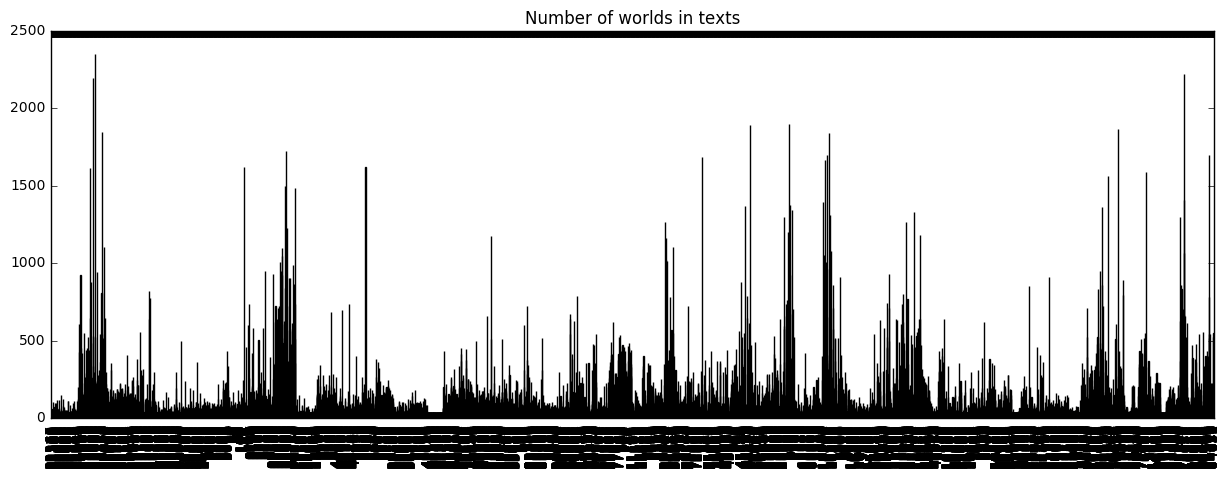

In [27]:
df.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

In [28]:
# Перемешать набор данных и удалить index столбец
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
for x in range(len(array_samples)):
    array_samples[x] = array_samples[x].sample(frac=1).reset_index(drop=True)

### Токенизация текста

In [16]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [17]:
# Убрать LowerCase

def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [29]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    char_filter = '«»—!–"−#$%&()*…,-./:;<=>?@[\\]^_`{|}~\t\n'
    gramms = {}
    gram_id = 0
    result = []
    for text in texts:
        for c_filter in char_filter:
            text = text.replace(c_filter, '')
        temp_vector = []
        count_grams_for_text = range(len(text) - count_gramm - 1)
        for i in count_grams_for_text:
            gramm = text[i : i + count_gramm]
            if gramm not in gramms:
                gramms[gramm] = gram_id
                gram_id += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
    print('Количество грамм в корпусе:', len(gramms))
    return result

In [19]:
array_X = []
for x in range(len(array_samples)):
    array_X.append(get_texts_to_gramm_sequences(array_samples[x]['Text'], count_gramm = 3))

Количество грамм в корпусе: 30133
Количество грамм в корпусе: 41801
Количество грамм в корпусе: 49736
Количество грамм в корпусе: 58561
Количество грамм в корпусе: 65964


In [20]:
array_grams = [30133, 41801, 49736, 58561, 65964]

In [19]:
#X = get_texts_to_matrix(data['Text'], 80000)
#X = get_texts_to_gramm_sequences(data['Text'])
#X = get_texts_to_sequences(data['Text'])

In [30]:
#X_gram_3 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 3)
X_gram_4 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 4)
#X_seq = get_texts_to_sequences(data['Text'])

Количество грамм в корпусе: 292945


In [24]:
array_X = [X_gram_3, X_gram_4]

In [22]:
def print_plot_mean(x):
    means = [len(x) for x in x]
    plt.plot(means);

In [25]:
len(array_X[0])
#print_plot_mean(X_gram_3)
#print_plot_mean(X_gram_4)
#print_plot_mean(X_seq)

2899

In [31]:
X = X_gram_4

640.309901319


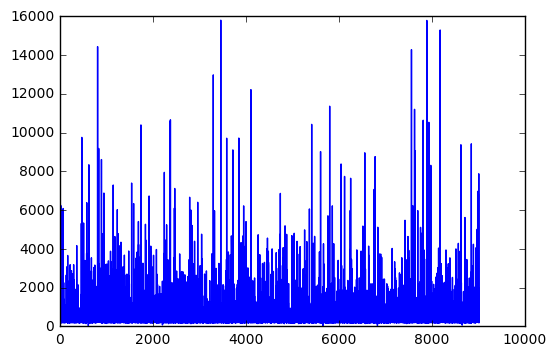

In [32]:
#plt.plot(X)
means = [len(x) for x in X]
print(np.mean(means))
plt.plot(means);
#X.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

### Разбиваем выборку на тестовую и тренировочную

In [23]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X, mode='binary')

    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words)     
    y = keras.utils.to_categorical(y, num_classes)
    print('Размерность X:', X.shape)
    print('Размерность y:', y.shape)
    return X, y

In [33]:
# Максимальное количество слов в самом длинном тексте
num_words = 4000
array_sets = []
X_full, y_full = get_X_y_for_traning(X_gram_4, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

Размерность X: (9019, 4000)
Размерность y: (9019, 100)


In [24]:
num_words = 4000
array_sets = []

for x in range(len(array_samples)):
    X_full, y_full = get_X_y_for_traning(array_X[x], array_samples[x].Author, num_words)
    array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

Размерность X: (1000, 4000)
Размерность y: (1000, 100)
Размерность X: (2000, 4000)
Размерность y: (2000, 100)
Размерность X: (3000, 4000)
Размерность y: (3000, 100)
Размерность X: (4000, 4000)
Размерность y: (4000, 100)
Размерность X: (5000, 4000)
Размерность y: (5000, 100)


In [30]:
# Максимальное количество слов в самом длинном тексте
num_words = 20000
# X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
array_sets = []
X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

X_full, y_full = get_X_y_for_traning(X_gram_4, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

#num_words = 2500
#X_full, y_full = get_X_y_for_traning(X_seq, data.Author, num_words)
#array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

#print('Testing set size:', len(X_test))
#print('Training set size:', len(X_train))

Размерность X: (41941, 20000)
Размерность y: (41941, 100)
Размерность X: (41941, 20000)
Размерность y: (41941, 100)


### Создание модели нейронной сети

In [54]:
def get_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_length, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
def get_bidirectional_lstm():
    model = Sequential()
    model.add(Embedding(80000, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
def get_conv_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
def get_conv_lstm_model():
    model = Sequential()
    #model.add(Dense(102562, activation='relu', input_shape=(8664, 600)))
    model.add(Embedding(100000, 200))
    model.add(SpatialDropout1D(0.3))
    #model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    #model.add(TimeDistributed(GlobalMaxPooling1D()))
    #model.add(TimeDistributed(Flatten()))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
def get_lstm_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
def get_conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
# ВК 4 грамма 

for x in range(len(array_sets)):
    X_train, X_test, y_train, y_test = array_sets[x]
    model = get_conv_model(embeding_size=292945)
    
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 10
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    #hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         58589000  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
Total params: 58,948,012
Trainable params: 58,948,012
Non-trainable params: 0
_________________________________________________________________
Train on 7215 samples, validate on 1804 samples
Epoch 1/10
71s - loss: 4.2107 - acc: 0.1149 - val_loss: 3.2867 - val_acc: 0.3115
E

In [26]:
# ДЛЯ ВК

for x in range(len(array_sets)):
    X_train, X_test, y_train, y_test = array_sets[x]
    model = get_conv_model(embeding_size=array_grams[x])
    
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 10
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    #hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         6026600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 6,385,612
Trainable params: 6,385,612
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/10
11s - loss: 4.6173 - acc: 0.0100 - val_loss: 4.6398 - val_acc: 0.0050
Epoch

In [44]:
for x in range(len(array_sets)):
    X_train, X_test, y_train, y_test = array_sets[x]
    model = get_conv_model(embeding_size=array_grams[x])
    
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 10
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    #hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         9540600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 9,899,612
Trainable params: 9,899,612
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 400 samples
Epoch 1/10
99s - loss: 4.6237 - acc: 0.0138 - val_loss: 4.6148 - val_acc: 0.0150
Epoc

In [ ]:
hist_array = []
for i, (X_train, X_test, y_train, y_test) in enumerate(array_sets):
    if i == 0:
        model = get_conv_model(embeding_size=143950) # 53.1 6-epoch
    if i == 1:
        model = get_conv_model(embeding_size=741852) # 53.1 6-epoch
    if i == 2:
        model = get_conv_model(embeding_size=1359198) # 53.1 6-epoch
        
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 10
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    #hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         28790000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 29,149,012
Trainable params: 29,149,012
Non-trainable params: 0
_________________________________________________________________
Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1371s - loss: 2.2435 - acc: 0.4698 - val_loss: 1.2052 - val_acc: 0.681

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 148370400 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1467s - loss: 2.1483 - acc: 0.4987 - val_loss: 1.1091 - val_acc: 0.7116
Epoch 2/10
1513s - loss: 0.7308 - acc: 0.8094 - val_loss: 0.8739 - val_acc: 0.7715
Epoch 3/10
1566s - loss: 0.3297 - acc: 0.9128 - val_loss: 0.8892 - val_acc: 0.7771
Epoch 4/10
1633s - loss: 0.1196 - acc: 0.9724 - val_loss: 0.8766 - val_acc: 0.7870
Epoch 5/10
1634s - loss: 0.0529 - acc: 0.9876 - val_loss: 0.9243 - val_acc: 0.7898
Epoch 6/10
1633s - loss: 0.0532 - acc: 0.9866 - val_loss: 1.0945 - val_acc: 0.7703
Epoch 7/10
1633s - loss: 0.0816 - acc: 0.9751 - val_loss: 1.1049 - val_acc: 0.7883
Epoch 8/10
1633s - loss: 0.0481 - acc: 0.9865 - val_loss: 1.3241 - val_acc: 0.7672
Epoch 9/10


In [26]:
X_train, X_test, y_train, y_test = array_sets[2]

model = get_conv_model(embeding_size=1359198) # 53.1 6-epoch

model.summary()

BATCH_SIZE = 8
EPOCHS = 10
VERBOSE = 2

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=VERBOSE,
                    validation_data=(X_test, y_test)
                    #validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         271839600 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 272,198,612
Trainable params: 272,198,612
Non-trainable params: 0
_________________________________________________________________


/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 271839600 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1313s - loss: 2.0779 - acc: 0.4987 - val_loss: 1.2015 - val_acc: 0.6852
Epoch 2/10
1298s - loss: 0.5818 - acc: 0.8517 - val_loss: 1.0358 - val_acc: 0.7355
Epoch 3/10
1294s - loss: 0.0694 - acc: 0.9855 - val_loss: 1.1773 - val_acc: 0.7192
Epoch 4/10
1289s - loss: 0.0301 - acc: 0.9926 - val_loss: 1.5661 - val_acc: 0.6690
Epoch 5/10
1289s - loss: 0.0271 - acc: 0.9927 - val_loss: 1.4401 - val_acc: 0.7010
Epoch 6/10
1291s - loss: 0.0208 - acc: 0.9940 - val_loss: 1.5282 - val_acc: 0.7052
Epoch 7/10
1289s - loss: 0.0199 - acc: 0.9948 - val_loss: 1.4818 - val_acc: 0.7196
Epoch 8/10
1292s - loss: 0.0159 - acc: 0.9958 - val_loss: 1.5540 - val_acc: 0.7190
Epoch 9/10
1293s - loss: 0.0218 - acc: 0.9941 - val_loss: 1.6801 - val_acc: 0.7101
Epoch 10/10
1275s - loss: 0.0082 - acc: 0.6891 - val_loss: 1.1921e-07 - val_acc: 0.0123


In [1]:
len(hist_array)

NameError: name 'hist_array' is not defined

In [ ]:
%%time
#model = get_lstm_model(120000) # 34.10 10-epoch
#model = get_bidirectional_lstm() # 50.86 20-epoch
model = get_conv_model() # 53.1 6-epoch
#model = get_conv_conv_model() # 54.04 7-epoch
#model = get_conv_lstm_model() # 53.17 10-epoch
#model = get_lstm_conv_model() # 52.60 10-epoch

model.summary()

BATCH_SIZE = 32
EPOCHS = 7
VERBOSE = 2

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=VERBOSE, 
                    validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         30192200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25650     
Total params: 30,525,562
Trainable params: 30,525,562
Non-trainable params: 0
_________________________________________________________________
Train on 21942 samples, validate on 2438 samples
Epoch 1/7
880s - loss: 1.6866 - acc: 0.5625 - val_loss: 0.8000 - val_acc: 0.7834


In [59]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=64, verbose=2)[1] * 100))

Точность модели составляет: 88.3182937009497


dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


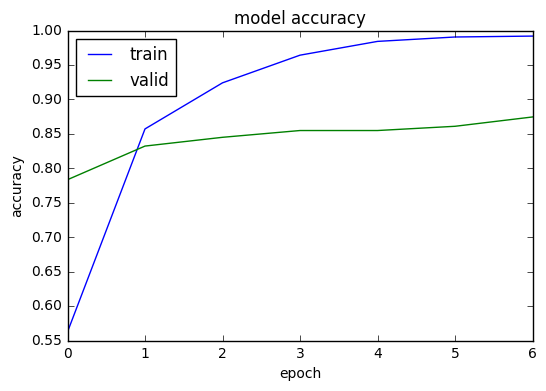

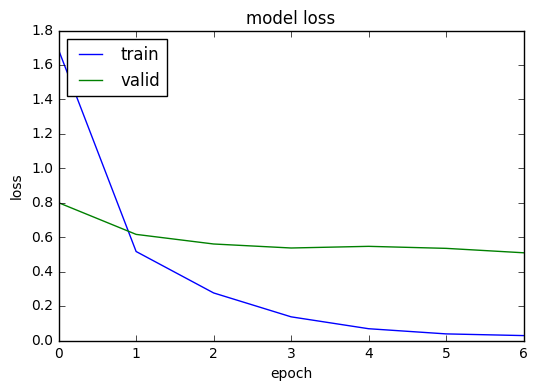

In [60]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

In [44]:
def save_model(model, model_name):
    # Генерируем описание модели в формате json
    model_json = model.to_json()
    # Записываем модель в файл
    json_file = open("model/{}_model.json".format(model_name), "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights("model/{}_weights.h5".format(model_name))
    print('Модель и веса успешно сохранены!')

In [58]:
save_model(model, 'vk_98percent_cnn')

Модель и веса успешно сохранены!
